In [6]:
import os
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import ot



## Define Path and load

In [7]:
china_root = "/home/espnet/egs2/aishell3/tts1/"
china_accent_path = "/home/espnet/egs2/aishell3/tts1/exp/tts_train_gst+xvector_conformer_fastspeech2_raw_phn_pypinyin_g2p_phone/ForMeasureDistance/pair_test_phn/latent"
taiwan_accent_root = "/home/espnet/egs2/chatbot/tts1/exp/tts_finetune_fastpeech2_reprogram_save_all_g2pw"
taiwan_accent_root_add = "/home/espnet/egs2/chatbot/tts1/exp/tts_finetune_fastpeech2_consistent_test_400_fixweight_e3_saveall_g2pw"


In [8]:
china_feats_dict={}
with open(os.path.join(china_accent_path,"feats.scp"),'r') as c:
    for line in c.readlines():
        uid, feats_path = line.strip("\n").split(" ")
        feats_path = os.path.join(china_root,feats_path)
        if os.path.exists(feats_path):
            china_feats_dict[uid] = feats_path 


In [9]:
import glob
epoch_feats_paths = glob.glob(os.path.join(taiwan_accent_root,"decode_*epoch"))
len(epoch_feats_paths)

16

In [11]:
taiwan_feats_dict = {}
for epoch_feats_path in epoch_feats_paths:
    folder_name = epoch_feats_path.split("/")[-1]
    taiwan_feats_dict[folder_name] = {}
    with open(os.path.join(epoch_feats_path,'test_phn','latent','feats.scp')) as f:
        for line in f.readlines():
            uid, feats_path = line.strip("\n").split(" ")
            feats_path = feats_path.replace("tts_finetune_fastpeech2_reprogram_decoder_Onlydependence_withlatent_save_all_g2pw","tts_finetune_fastpeech2_reprogram_save_all_g2pw")
            # feats_path.replace(""tts_finetune_fastpeech2_reprogram_save_all_g2pw")
            feats_path = "../" + feats_path
            if os.path.exists(feats_path):
                taiwan_feats_dict[folder_name][uid] = feats_path 
            else:
                print(feats_path)

taiwan_feats_dict_keys = sorted(taiwan_feats_dict, key=lambda x: int(x.lstrip('decode_').rstrip("epoch")))

In [10]:
epoch_feats_paths_add = glob.glob(os.path.join(taiwan_accent_root_add,"decode_*epoch"))
taiwan_feats_dict_add = {}
for epoch_feats_path in epoch_feats_paths_add:
    folder_name = epoch_feats_path.split("/")[-1]
    print(folder_name)
    taiwan_feats_dict_add[folder_name] = {}
    with open(os.path.join(epoch_feats_path,'test_phn','latent','feats.scp')) as f:
        for line in f.readlines():
            uid, feats_path = line.strip("\n").split(" ")
            if os.path.exists(feats_path):
                taiwan_feats_dict_add[folder_name][uid] = feats_path 

In [11]:
taiwan_feats_dict_keys_add= sorted(taiwan_feats_dict_add, key=lambda x: int(x.lstrip('decode_').rstrip("epoch")))

In [12]:

class wd_criterion(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, t,c):
        if t.shape[0] > c.shape[0]:
            pad = torch.zeros(t.shape[0]-c.shape[0]).to(t.device)
            c = torch.cat((c,pad),dim=0)
        else:
            pad = torch.zeros(c.shape[0]-t.shape[0]).to(t.device)
            t = torch.cat((t,pad),dim=0)
        # print(t.shape, c.shape)
        # Wass_xy = self.Loss(t.unsqueeze(0),c.unsqueeze(0))
        M = ot.utils.dist(t.unsqueeze(0),c.unsqueeze(0), 'euclidean')
        alpha = torch.tensor(ot.unif(len(t.unsqueeze(0)))).to(t.device)
        beta = torch.tensor(ot.unif(len(c.unsqueeze(0)))).to(t.device)
        M2 = pow(M, 2)
        pW = ot.emd2(alpha, beta, M2, numItermplt=100000)
        pW = pow(pW, 1/2)
        
        return pW

class MMD_loss(nn.Module):
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        if source.shape[1] > target.shape[1]:
            pad = torch.zeros(source.shape[0],source.shape[1]-target.shape[1]).to(source.device)
            target = torch.cat((target,pad),dim=1)
        else:
            pad = torch.zeros(target.shape[0],target.shape[1]-source.shape[1]).to(source.device)
            source = torch.cat((source,pad),dim=1)
        # print(source.shape)
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        # print(kernels.shape)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX) + torch.mean(YY) - torch.mean(XY) -  torch.mean(YX)
        return loss

In [13]:
mmd_criterion = MMD_loss()
wd_criterion = wd_criterion()
device = "cuda:0"

## Do Not ADD LOSS

#### SWD

In [17]:
from espnet.nets.pytorch_backend.nets_utils import make_non_pad_mask

In [14]:
difference = {}
c_len = [[] for _ in range(len(taiwan_feats_dict_keys))]
t_len = [[] for _ in range(len(taiwan_feats_dict_keys))]
i=0
for epoch in tqdm(taiwan_feats_dict_keys,total=len(taiwan_feats_dict_keys)):
    before, after = [0 for _ in range(5)], [0 for _ in range(5)]
    for idx, key in enumerate(china_feats_dict):
        china = np.load(china_feats_dict[key])
        c = torch.from_numpy(china).to(device)
        c_len[i].append(c.shape[2])
        difference[f'epoch_{epoch}'] = {
            f'before_wd': [],
            f'after_wd': []}
        t = np.load(taiwan_feats_dict[epoch][key])
        t = torch.from_numpy(t).to(device)
        t_len[i].append(t.shape[2])
        for layer_id in range(len(c)-1):
            loss = wd_criterion(t[layer_id*2].view(-1),c[layer_id].view(-1))
            before[layer_id] += loss.item()
            loss = wd_criterion(t[layer_id*2+1].view(-1),c[layer_id].view(-1))
            after[layer_id] += loss.item()
    difference[f'epoch_{epoch}'].update({
        f'before_wd': [1e-3*each/len(china_feats_dict.keys()) for each in before],
        f'after_wd': [1e-3*each/len(china_feats_dict.keys()) for each in after]})
    i+=1


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


#### MMD

In [15]:
device = "cpu"

In [18]:

c_batch = 0
for idx, key in enumerate(china_feats_dict):
    china = np.load(china_feats_dict[key])
    c = torch.from_numpy(china).to(device)
    pad = torch.zeros(c.shape[0],c.shape[1],mplt(c_len[0])-c.shape[2],c.shape[3]).to(device)
    c_pad = torch.cat((c,pad),dim=2)
    if idx == 0:
        c_batch  = c_pad
    else:
        c_batch  = torch.cat((c_batch,c_pad),dim=1)
c_mask = make_non_pad_mask(c_len[0]).unsqueeze(-1).to(device)

In [19]:

t_epoch = []
for i, epoch in tqdm(enumerate(taiwan_feats_dict_keys),total=len(taiwan_feats_dict_keys)):
   t_batch = 0
   for idx, key in enumerate(taiwan_feats_dict[epoch]):
      t = np.load(taiwan_feats_dict[epoch][key])
      t = torch.from_numpy(t).to(device)
      pad = torch.zeros(t.shape[0],t.shape[1],max(t_len[i])-t.shape[2],t.shape[3]).to(device)
      t_pad = torch.cat((t,pad),dim=2)
      if idx == 0:
         t_batch  = t_pad
      else:
         t_batch  = torch.cat((t_batch,t_pad),dim=1)
   t_epoch.append(t_batch)

100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


In [21]:
device = "cuda:0"
import gc

In [22]:
b = 10
for i, epoch in tqdm(enumerate(taiwan_feats_dict_keys),total=len(taiwan_feats_dict_keys)):
    t = t_epoch[i]
    t_mask = make_non_pad_mask(t_len[i]).unsqueeze(-1)
    before, after = [0 for _ in range(5)], [0 for _ in range(5)]
    for layer_id in range(0, t.shape[0]-1,2):
        for batch in range(0,50,b):
            pair_ = c_batch[int(layer_id/2),batch:batch+b].masked_fill(mask=~c_mask[batch:batch+b], value=0).to(device)
            t_be = t[layer_id,batch:batch+b].masked_fill(~t_mask[batch:batch+b], value=0).to(device)

            pair_ = pair_.view(pair_.size(0),-1)
            t_be = t_be.view(t_be.size(0),-1)
            before[int(layer_id/2)] += mmd_criterion(pair_,t_be).item()
            del t_be
            gc.collect()
            torch.cuda.empty_cache()
            t_af = t[layer_id+1,batch:batch+b].masked_fill(~t_mask[batch:batch+10], value=0).to(device)
            t_af = t_af.view(t_af.size(0),-1)
            after[int(layer_id/2)] += mmd_criterion(pair_,t_af).item()
            del pair_, t_af
            gc.collect()
            torch.cuda.empty_cache()
            gc.collect()
    difference[f'epoch_{epoch}'].update({
        f'before_mmd': [each/2 for each in before],
        f'after_mmd': [each/2 for each in after]})

100%|██████████| 16/16 [01:17<00:00,  4.86s/it]


## ADD LOSS

In [16]:
difference_add = {}
for idx, key in tqdm(enumerate(china_feats_dict),total=50):
    china = np.load(china_feats_dict[key])
    c = torch.from_numpy(china).to(device)
    # c = c.repeat(2,1,1,1)
    # print(key)
    difference_add[key] = {}
    for epoch in taiwan_feats_dict_keys_add:
        t = np.load(taiwan_feats_dict_add[epoch][key])
        t = torch.from_numpy(t).to(device)
        if t.shape[2]> c.shape[2]:
            # print(t.shape,c.shape)
            pad = torch.zeros(c.shape[0],c.shape[1],t.shape[2]-c.shape[2],c.shape[3]).to(device)
            c_p = torch.cat((c,pad),dim=2).to(device)
            t_p = t
        else:
            pad = torch.zeros(t.shape[0],t.shape[1],c.shape[2]-t.shape[2],t.shape[3]).to(device)
            t_p = torch.cat((t,pad),dim=2).to(device)
            c_p = c
        t_p = t_p.squeeze(1)
        c_p = c_p.squeeze(1)
        # print(t_p.shape,c_p.shape)
        before, after = [], []
        for layer_id in range(len(c_p)-1):
            M = ot.utils.dist(t_p[layer_id*2],c_p[layer_id], 'euclidean')
            alpha = torch.tensor(ot.unif(len(t_p[layer_id*2]))).to(device)
            beta = torch.tensor(ot.unif(len(c_p[layer_id]))).to(device)
            M2 = pow(M, 2)
            pW = ot.emd2(alpha, beta, M2, numItermax=100000)
            pW = pow(pW, 1/2)
            before.append(pW)
            M = ot.utils.dist(t_p[layer_id*2+1],c_p[layer_id], 'euclidean')
            alpha = torch.tensor(ot.unif(len(t_p[layer_id*2+1]))).to(device)
            beta = torch.tensor(ot.unif(len(c_p[layer_id]))).to(device)
            M2 = pow(M, 2)
            pW = ot.emd2(alpha, beta, M2, numItermax=100000)
            pW = pow(pW, 1/2)
            after.append(pW)

            # print(t_p[layer_id*2].reshape(-1)==t_p[layer_id*2+1].reshape(-1))
        difference_add[key][f'epoch_{epoch}'] = {
            f'before': before,
            f'after': after}

100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


## Plot

In [1]:
import matplotlib.pyplot as plt 

In [23]:

data_epoch = []
for epoch in difference:
    # epoch_mean = [(sum(difference[epoch]['before_wd'][:4])/4),(sum(difference[epoch]['after_wd'][:4])/4)]
    epoch_mean = [(sum(difference[epoch]['before_wd'][:4])/4),(sum(difference[epoch]['after_wd'][:4])/4),(sum(difference[epoch]['before_mmd'][:4])/4),(sum(difference[epoch]['after_mmd'][:4])/4)]
    # print(epoch_mean)
    data_epoch.append(epoch_mean)
len(data_epoch)
np.save("data.npy",np.array(data_epoch)) # save data for convinent

In [2]:
import numpy as np
data_epoch = np.load("data.npy")

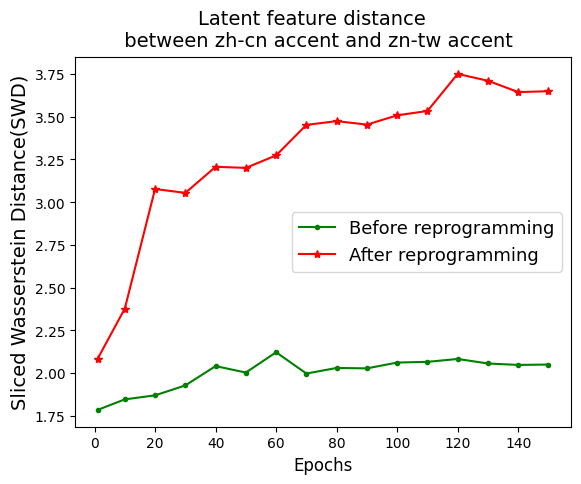

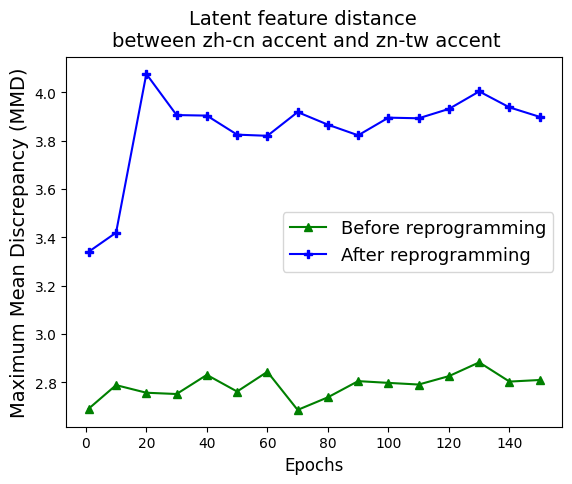

In [15]:

# fig = plt.figure()
plt.subplot()
# plt.title("Latent feature distance between zh-cn accent and zn-tw accent")
lns1 =plt.plot([1]+list(range(10,151,10)),[each[0] for each in data_epoch[:16]],label="Before reprogramming",marker='.', c='green')
lns2 =plt.plot([1]+list(range(10,151,10)),[each[1] for each in data_epoch[:16]], label="After reprogramming",marker='*', c='r')
plt.xlabel("Epochs", fontsize = 12)
# set y-pltis label
plt.ylabel("Sliced Wasserstein Distance(SWD)", fontsize=14)
lns = lns1+lns2
labs = [l.get_label() for l in lns]
plt.legend(lns,labs, markerscale=1,  fontsize = 13)
plt.suptitle("Latent feature distance \n between zh-cn accent and zn-tw accent",fontsize = 14)
plt.show()
plt.subplot()

# plt.title("Latent feature distance between zh-cn accent and zn-tw accent")
lns3 =plt.plot([1]+list(range(10,151,10)),[each[2] for each in data_epoch[:16]],label="Before reprogramming", c='green',marker="^")
lns4 =plt.plot([1]+list(range(10,151,10)),[each[3] for each in data_epoch[:16]], label="After reprogramming",c='b', marker="P")
# plt.plot([1]+list(range(10,101,10)),before_data_mean_add,label="Add loss: Before reprogramming ",marker='.')
# plt.plot([1]+list(range(10,101,10)),after_data_mean_add, label="Add loss: After reprogramming",marker='*')
plt.ylabel("Maximum Mean Discrepancy (MMD)", fontsize=14)
plt.xlabel("Epochs", fontsize = 12)
lns = lns3+lns4
labs = [l.get_label() for l in lns]
plt.legend(lns,labs,loc='center right',markerscale=1, fontsize = 13)
plt.suptitle("Latent feature distance \nbetween zh-cn accent and zn-tw accent",fontsize = 14)
plt.show()


In [115]:
import matplotlib.pyplot as plt 
layer_dis = []
for each in difference:
    dis = [[[e.item() for e in difference[each][epoch]['before']],[e.item() for e in difference[each][epoch]['after']]] for epoch in difference[each]]
    # print(dis)
    layer_dis.append(dis)
print(np.array(layer_dis).shape)
print(np.array(layer_dis)[:,:,0,:].mean(axis=0).shape)
# before_data = [[each[i][0] for i in range(16)] for each in data_epoch]
# after_data = [[each[i][1] for i in range(16)] for each in data_epoch]
before_data_layer_mean = np.array(layer_dis)[:,:,0,:].mean(axis=0).transpose(0,1)
after_data_layer_mean = np.array(layer_dis)[:,:,1,:].mean(axis=0).transpose(0,1)

(50, 16, 2, 5)
(16, 5)


In [116]:
import matplotlib.pyplot as plt 
layer_dis_add = []
for each in difference_add:
    dis = [[[e.item() for e in difference_add[each][epoch]['before']],[e.item() for e in difference_add[each][epoch]['after']]] for epoch in difference_add[each]]
    # print(dis)
    layer_dis_add.append(dis)
print(np.array(layer_dis_add).shape)
print(np.array(layer_dis_add)[:,:,0,:].mean(axis=0).shape)
# before_data = [[each[i][0] for i in range(16)] for each in data_epoch]
# after_data = [[each[i][1] for i in range(16)] for each in data_epoch]
before_data_layer_mean_add = np.array(layer_dis_add)[:,:,0,:].mean(axis=0).transpose(0,1)
after_data_layer_mean_add = np.array(layer_dis_add)[:,:,1,:].mean(axis=0).transpose(0,1)

(50, 11, 2, 4)
(11, 4)


In [77]:
before_data_layer_mean_add.shape

(11, 4)

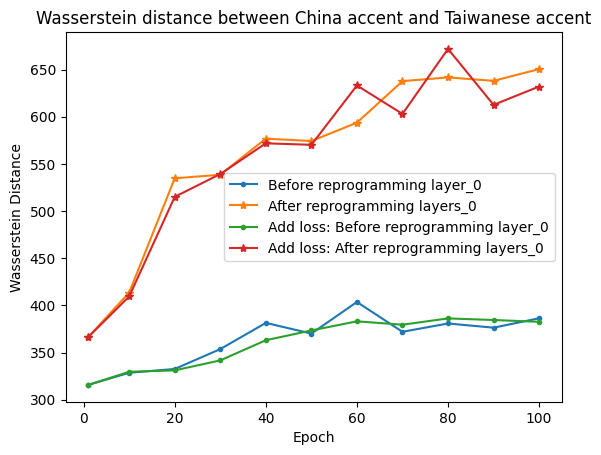

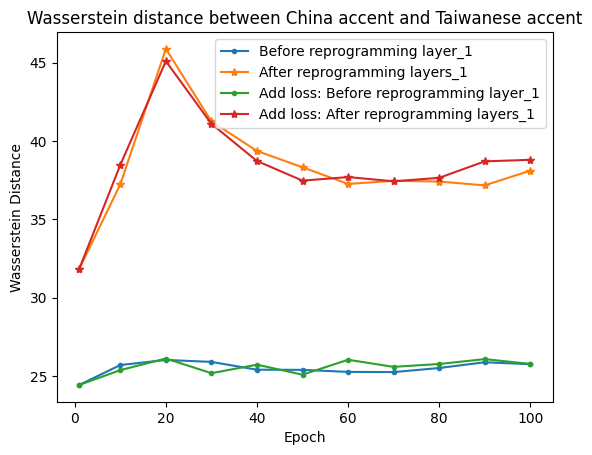

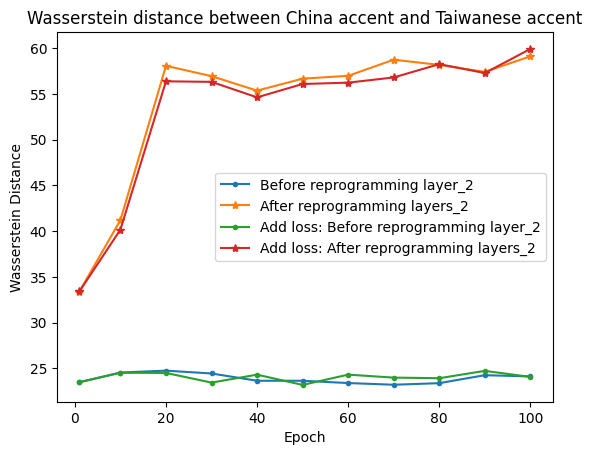

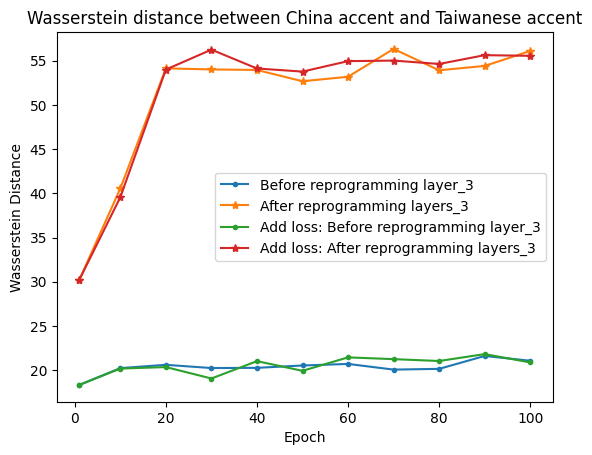

In [117]:
for i in range(4):
    plt.figure()
    plt.title("Wasserstein distance between China accent and Taiwanese accent")
    plt.plot([1]+list(range(10,101,10)),before_data_layer_mean[:11,i],label=f"Before reprogramming layer_{i}",marker='.')
    plt.plot([1]+list(range(10,101,10)),after_data_layer_mean[:11,i], label=f"After reprogramming layers_{i}",marker='*')
    plt.plot([1]+list(range(10,101,10)),before_data_layer_mean_add[:,i],label=f"Add loss: Before reprogramming layer_{i}",marker='.')
    plt.plot([1]+list(range(10,101,10)),after_data_layer_mean_add[:,i], label=f"Add loss: After reprogramming layers_{i}",marker='*')
    plt.xlabel("Epoch")
    plt.ylabel("Wasserstein Distance")
    plt.legend()
    plt.show()

In [83]:
import librosa
d_100 = 0
with open("/home/espnet/egs2/chatbot/tts1/data/train_no_dev_test_phn_100/wav.scp") as s:
    lines = s.readlines()
    for line in lines:
        id, wav_name = line.split(" ")
        d = librosa.get_duration(filename=wav_name.strip("\n"))
        d_100 += d
d_100/60

4.588263038548752

In [84]:
import librosa
d_100 = 0
with open("/home/espnet/egs2/chatbot/tts1/data/train_no_dev_test_phn_300/wav.scp") as s:
    lines = s.readlines()
    for line in lines:
        id, wav_name = line.split(" ")
        d = librosa.get_duration(filename=wav_name.strip("\n"))
        d_100 += d
d_100/60

13.749309145880577

In [85]:
import librosa
d_100 = 0
with open("/home/espnet/egs2/chatbot/tts1/data/train_no_dev_test_phn_500/wav.scp") as s:
    lines = s.readlines()
    for line in lines:
        id, wav_name = line.split(" ")
        d = librosa.get_duration(filename=wav_name.strip("\n"))
        d_100 += d
d_100/60

23.031873015873035

In [2]:
import torch
import torch.nn.functional as F
from torch import nn


def gaussian_kernel(x, y, beta=1.0):
    r = x.t()
    r = r.unsqueeze(2)
    res = torch.exp(-1.0 * beta * (r - y).pow(2).sum(dim=-1))
    return res


def mmd_distance(x, y, kernel=gaussian_kernel, kernel_args=None):
    if kernel_args is None:
        kernel_args = {}

    xx = kernel(x, x, **kernel_args)
    yy = kernel(y, y, **kernel_args)
    xy = kernel(x, y, **kernel_args)
    
    mmd = xx.mean() + yy.mean() - 2 * xy.mean()
    return mmd


In [3]:
class MMD_loss(nn.Module):
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    def guassian_kernel(self, source, target, kernel_mul=1.0, kernel_num=3, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        # if source.shape[0] > target.shape[0]:
        #     pad = torch.zeros(source.shape[0]-target.shape[0]).to(source.device)
        #     target = torch.cat((target,pad),dim=0)
        # else:
        #     pad = torch.zeros(target.shape[0]-source.shape[0]).to(source.device)
        #     source = torch.cat((source,pad),dim=0)
        # source = source.unsqueeze(0)
        # target = target.unsqueeze(0)
        # print(source.shape)
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        # print(kernels.shape)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX) + torch.mean(YY) - torch.mean(XY) -  torch.mean(YX)
        # target = F.normalize(target, p=2, dim=1)
        # source = F.normalize(source, p=2, dim=1)

        # loss = self.gaussian_kernel(target, target).mean() \
        #         + self.gaussian_kernel(source, source).mean() \
        #         - 2 * self.gaussian_kernel(target, source).mean()
        return loss

In [ ]:
from torch_two_sampele import MMDStatistic

In [88]:
import torch

# generate some example data
x = torch.randn(2, 10).cuda()
y = torch.randn(2, 10).cuda()
mmd_loss = MMD_loss()
# compute the MMD distance
mmd = mmd_distance(x, y)
# mmd_ = MMDStatistic(3,3)

loss = mmd_loss(x,y)
# loss = mmd_
print('MMD distance:', mmd.item())
# print('MMD distance:', mmd.item())
print('MMD distance:', loss.item())



MMD distance: -0.005592647939920425
MMD distance: 2.4209237098693848
